### Import das bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from imblearn.over_sampling import SMOTE
from joblib import dump, load
import os


### Seleciona acelX, acelY, acelZ e atividade

In [22]:
dfs = []

base_path = "C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Dataset-FallWatch"
for i in range(1,6):
    folder_name_avd = f"U{i:02d}\\AVD's"
    folder_name_fall = f"U{i:02d}\\Falls"
    
    folder_path_avd = os.path.join(base_path, folder_name_avd)
    folder_path_fall = os.path.join(base_path, folder_name_fall)
    
    for j in range(1, 12):
        file_name_avd = f'U{i:02d} - D{j:02d}.csv'
        file_path_avd = os.path.join(folder_path_avd, file_name_avd)
        
        file_name_fall = f'U{i:02d} - F{j:02d}.csv'
        file_path_fall = os.path.join(folder_path_fall, file_name_fall)
        
        if os.path.exists(file_path_avd):
            df = pd.read_csv(file_path_avd)
            df['idTipoMovimento'] = f'D{j:02d}'
            dfs.append(df)
            
        if os.path.exists(file_path_fall):
            df = pd.read_csv(file_path_fall)
            df['idTipoMovimento'] = f'F{j:02d}'
            dfs.append(df)

dataframe = pd.concat(dfs, ignore_index=True)

movimentos_formatados = {"D01":"Caminhando",
"D02":"Correndo",
"D03":"Subindo e descendo escadas",
"D04":"Sentando em uma cadeira, esperar um momento e levantar-se",
"D05":"Sentado por um momento, tentar levantar-se e cair na cadeira",
"D06":"Agachando (dobrando os joelhos), amarrar sapatos e levantar-se",
"D07":"Tropeçar enquanto caminha",
"D08":"Pular suavemente sem cair(tentando alcançar um objeto)",
"D09":"Bater na mesa com a mão",
"D10":"Batendo palmas",
"F01":"Queda para frente ao caminhar causada por escorregão",
"F02":"Queda lateral ao caminhar causada por escorregão",
"F03":"Queda para trás ao caminhar causada por escorregão",
"F04":"Queda para frente ao caminhar causada por tropeço",
"F05":"Queda para trás ao tentar sentar-se",
"F06":"Queda para frente enquanto sentado, causada por desmaio ou adormecimento",
"F07":"Queda para trás enquanto sentado, causada por desmaio ou adormecimento",
"F08":"Queda lateral enquanto sentado, causada por desmaio ou adormecimento",
}

colunas_selecionadas = ['acelX', 'acelY', 'acelZ' ,'idTipoMovimento']
dataframe = dataframe[colunas_selecionadas]
dataframe['MAGNITUDE_ACEL']   = np.sqrt(dataframe['acelX']**2 + dataframe['acelY']**2 + dataframe['acelZ']**2)
dataframe = dataframe[dataframe['idTipoMovimento'].isin(['D01', 'D02', 'F01'])]
dataframe

,acelX,acelY,acelZ,idTipoMovimento,MAGNITUDE_ACEL
0,-91.0,221.0,-1835.0,D01,1850.499122
1,-88.0,339.0,-1866.0,D01,1898.583946
2,-26.0,263.0,-1835.0,D01,1853.933656
3,-57.0,293.0,-1887.0,D01,1910.462509
4,-37.0,207.0,-1911.0,D01,1922.534525
...,...,...,...,...,...
37570,-1678.0,175.0,929.0,D02,1925.967289
37571,-610.0,670.0,580.0,D02,1075.825265
37572,-422.0,778.0,224.0,D02,912.986309
37573,-1511.0,790.0,-350.0,D02,1740.609376


### Mensurar volume do dataset

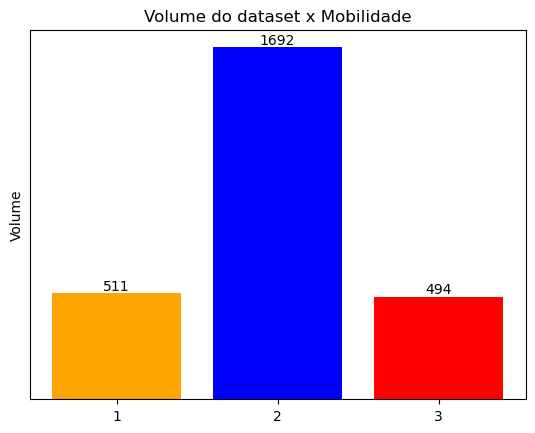

In [12]:
# id_andando  = df_andando['idTipoMovimento'][0]
# id_correndo = df_correndo['idTipoMovimento'][0]
# id_caindo   = df_caindo['idTipoMovimento'][0]

# eixo_x = [id_andando, id_correndo, id_caindo]
# contagem = [len(df_andando),len(df_correndo),len(df_caindo)]
# cores_barras = ['blue','orange','red']
# legenda_barras = ['andando','correndo','caindo']

# fig, ax = plt.subplots()

# bar_container = ax.bar(eixo_x, contagem, label=legenda_barras, color=cores_barras)
# ax.bar_label(bar_container, fmt='{:.0f}')
# ax.set_title('Volume do dataset x Mobilidade')
# # ax.set_xlabel('Mobilidade')
# ax.set_ylabel('Volume')
# # ax.legend()
# plt.yticks([]) # Remover escala do eixo y
# plt.xticks(eixo_x)
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\volume_dataset_por_mobilidade.png')
# plt.show()

### Treinamento e teste do modelo (todas as mobilidades)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(dataframe[['acelX','acelY','acelZ','MAGNITUDE_ACEL']], dataframe['idTipoMovimento'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\knn_matriz_confusao_todos_os_movimentos.png', dpi=300, bbox_inches='tight')

with open('modelos/knn_model.joblib', 'wb') as file:
    dump(knn, file)


[[468   3  41]
 [ 18 487   7]
 [ 64   8 407]]
              precision    recall  f1-score   support

         D01       0.85      0.91      0.88       512
         D02       0.98      0.95      0.96       512
         F01       0.89      0.85      0.87       479

    accuracy                           0.91      1503
   macro avg       0.91      0.90      0.91      1503
weighted avg       0.91      0.91      0.91      1503



In [30]:
df_teste_modelo = dataframe[dataframe['idTipoMovimento'].isin(['D02'])]
df_teste_modelo = df_teste_modelo.drop(columns=['idTipoMovimento'])
# df_teste_modelo
with open('modelos/knn_model.joblib', 'rb') as file:
    knn_loaded = load(file)
    
X_test = df_teste_modelo

y_pred = knn_loaded.predict(X_test)

print("Previsões: ", y_pred)

# with open('predicoes/knn_predicoes.txt', 'w') as f:
#     for pred in y_pred:
#         f.write(f"{pred}\n")

# print("Previsões salvas no arquivo 'predicoes/knn_predicoes.txt'")

c:\Users\julia\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Previsões:  ['D02' 'D02' 'F01' ... 'D02' 'D02' 'D02']
